#**Traffic monitoring system using stereo cameras to detect vehicles**

In [ ]:
!pip install yolov5 torch torchvision

In [ ]:
from tabulate import tabulate
import yolov5

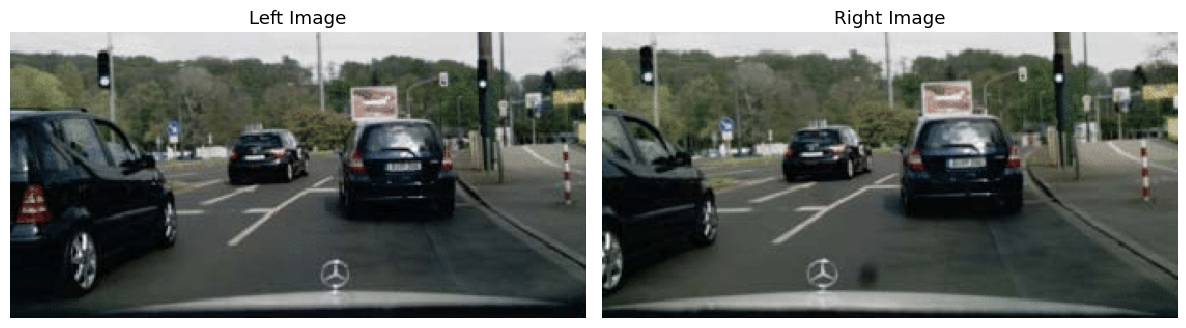

In [ ]:
left_img = cv2.imread("traffic1.png")
right_img = cv2.imread("traffic2.png")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
plt.title("Left Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
plt.title("Right Image")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def compute_disparity(left_img, right_img):
    left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
    stereo = cv2.StereoBM_create(numDisparities=16*5, blockSize=15)
    disparity = stereo.compute(left_gray, right_gray).astype(np.float32) / 16.0
    return disparity

def compute_depth(disparity, focal_length, baseline):
    disparity = np.float32(disparity)
    disparity[disparity == 0] = 0.1  # Avoid division by zero
    depth = (focal_length * baseline) / disparity
    return depth

def detect_vehicles(image):
    model = yolov5.load('yolov5s.pt')
    model.conf = 0.5  # Higher confidence for cars
    model.iou = 0.4   # Merge overlapping boxes
    results = model(image)
    vehicles = []
    for det in results.xywh[0]:
        x, y, w, h, conf, cls = det
        if cls == 2:  # Only cars
            vehicles.append((int(x-w/2), int(y-h/2), int(w), int(h), conf))
    return vehicles

def estimate_vehicle_distances(depth_map, vehicles):
    distances = []
    for i, (x, y, w, h, conf) in enumerate(vehicles):
        vehicle_depth = depth_map[y:y+h, x:x+w]
        valid_depths = vehicle_depth[np.isfinite(vehicle_depth) & (vehicle_depth > 0)]
        if len(valid_depths) > 0:
            avg_distance = np.mean(valid_depths)
            distances.append((f"Vehicle {i+1}", avg_distance, conf))
        else:
            distances.append((f"Vehicle {i+1}", "Unknown", conf))
    return distances

def visualize_detections(image, vehicles):
    img_copy = image.copy()
    for i, (x, y, w, h, conf) in enumerate(vehicles):
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
        label = f"Car {i+1} ({conf:.2f})"
        cv2.putText(img_copy, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return img_copy


/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


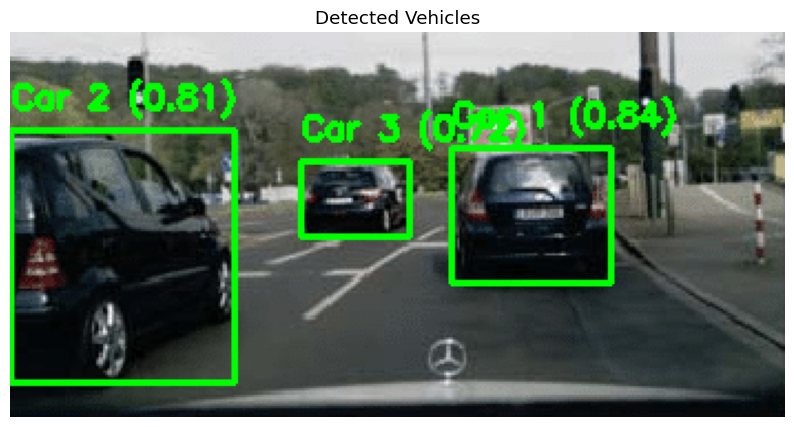

In [ ]:
# Detect and visualize vehicles
vehicles = detect_vehicles(left_img)

# Visualize
vis_img = visualize_detections(left_img, vehicles)
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.title('Detected Vehicles')
plt.axis('off')
plt.show()


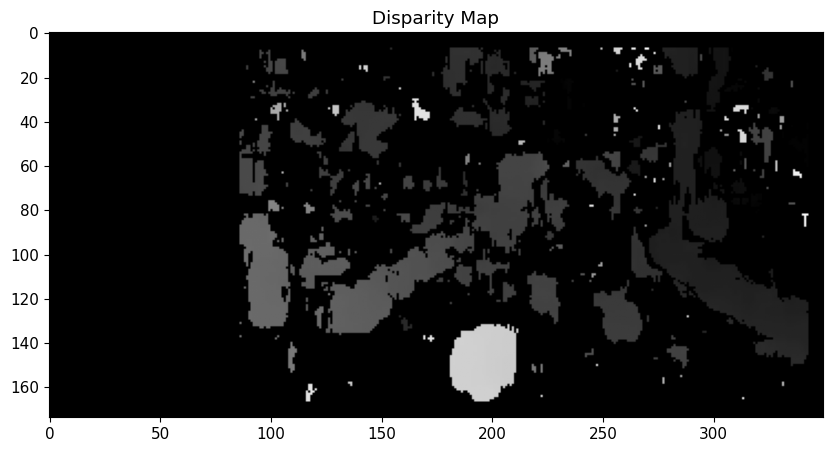

In [ ]:
# Compute and visualize disparity map
disparity = compute_disparity(left_img, right_img)

# Normalize for visualization
disparity_vis = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_vis = np.uint8(disparity_vis)

# Display

plt.figure(figsize=(10, 5))
plt.imshow(disparity_vis, cmap='gray')
plt.title('Disparity Map')

plt.show()

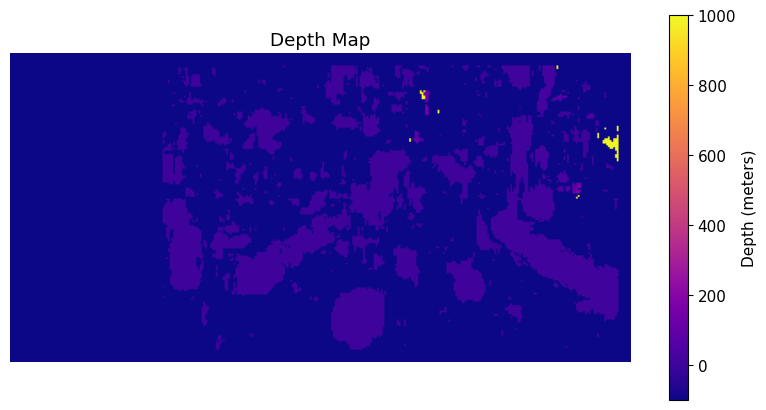

In [ ]:
# Compute and visualize depth map
focal_length = 1000  # in pixels
baseline = 0.1       # in meters

depth = compute_depth(disparity, focal_length, baseline)

# Display
plt.figure(figsize=(10, 5))
plt.imshow(depth, cmap='plasma')
plt.title('Depth Map')
plt.colorbar(label='Depth (meters)')
plt.axis('off')
plt.show()


In [ ]:
# Estimate vehicle distances and print table
distances = estimate_vehicle_distances(depth, vehicles)

# Display table
print("\nVehicle Distances from Camera:")
print(tabulate(distances, headers=["Vehicle", "Distance (meters)", "Confidence"], tablefmt="grid"))


Vehicle Distances from Camera:
+-----------+---------------------+--------------+
| Vehicle   |   Distance (meters) |   Confidence |
+===========+=====================+==============+
| Vehicle 1 |             5.63823 |     0.837321 |
+-----------+---------------------+--------------+
| Vehicle 2 |             3.51486 |     0.812776 |
+-----------+---------------------+--------------+
| Vehicle 3 |             5.23421 |     0.716166 |
+-----------+---------------------+--------------+
